In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io, transform

import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.lib.io import file_io

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
EPOCHS = 100
BS = 128
DROPOUT_RATE = 0.35
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
def get_datagen(dataset):
    # Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
    # rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
    # rotation_range:   Int. Degree range for random rotations
    # shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    # zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
    # fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
    # horizontal_flip:  Boolean. Randomly flip inputs horizontally
    datagen = ImageDataGenerator(
                        rescale=1./255,
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [0]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-public.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-private.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/train.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/jaffe.zip' -d train

replace train/0 angry/desktop.ini? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam-us.zip' -d dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam-pk.zip' -d dev

In [0]:
# Move 80% of webcam images to the training set
%%bash
source_root='/content/dev/'
target_root='/content/train/'
IFS=$(echo -en "\n\b")
for dir in $(ls -1 "$source_root")
do
    source_dir="$source_root$dir"
    target_dir="$target_root$dir"
    num_files=$(ls -1 "$source_dir" | wc -l)
    num_to_move=$(( $num_files*8/10 ))
    echo "Moving $num_to_move/$num_files files from $source_dir to $target_dir"
    mkdir -p "$target_dir"
    cd "$source_dir"
    ls -1 "$source_dir" | shuf -n $num_to_move | xargs -i mv {} "$target_dir"
 done

Moving 29/37 files from /content/dev/0 angry to /content/train/0 angry
Moving 34/43 files from /content/dev/1 disgust to /content/train/1 disgust
Moving 18/23 files from /content/dev/2 fear to /content/train/2 fear
Moving 22/28 files from /content/dev/3 happy to /content/train/3 happy
Moving 21/27 files from /content/dev/4 sad to /content/train/4 sad
Moving 20/25 files from /content/dev/5 surprise to /content/train/5 surprise
Moving 21/27 files from /content/dev/6 neutral to /content/train/6 neutral


In [0]:
# FER2013 has 35,887 labeled images, which are divided into 3589 test and 28709 train images.
X_train_gen  = get_datagen('/content/train')

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 37791 images belonging to 7 classes.


In [0]:
X_dev_gen    = get_datagen('/content/dev')

X_dev = np.zeros((len(X_dev_gen.filepaths), 48, 48, 1))
Y_dev = np.zeros((len(X_dev_gen.filepaths), 7))
for i in range(0,len(X_dev_gen.filepaths)):
  x = io.imread(X_dev_gen.filepaths[i], as_gray=True)
  X_dev[i,:] = transform.resize(x, (48,48,1))
  Y_dev[i,X_dev_gen.classes[i]] = 1

Found 43 images belonging to 7 classes.


In [0]:
# Implement below paper CPCPCPFF depth 5, 2.4m params
# https://www.semanticscholar.org/paper/Fusing-Aligned-and-Non-aligned-Face-Information-for-Kim-Dong/90044a889edb4a2095d0a2a5b02a22043d73a0b9

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Conv2D(32, (4, 4), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Conv2D(64, (5, 5), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

sgd=SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
# Learning rate is reduced by a factor of 2
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

In [0]:
history = model.fit_generator(
    generator = X_train_gen,
    validation_data = (X_dev, Y_dev),
    shuffle=True,
    callbacks=[rlrop],
    epochs=EPOCHS)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 296 steps, validate on 43 samples
296/296 [==============================] - 41s 139ms/step - loss: 0.8907 - accuracy: 0.6674 - val_loss: 1.0453 - val_accuracy: 0.6977


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


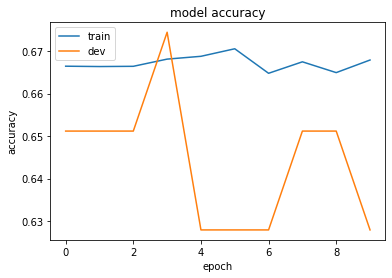

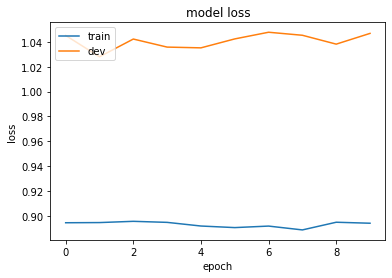

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [0]:
results_webcam = model.evaluate(X_dev, Y_dev, batch_size=BS)

lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = 'test_acc_%.3f' % results_webcam[1]
filename = '/content/drive/My Drive/cs230 project/models/webcam' + lr_str + epoch_str + bs_str + dropout_str + test_acc + '.h5'
print(f'Saving model to {filename}...')
model.save(filename)

43/43 [==============================] - 0s 158us/sample - loss: 1.0453 - accuracy: 0.6977
Saving model to /content/drive/My Drive/cs230 project/models/webcam-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.35test_acc_0.698.h5...
